# Abnormality Detection in Bone X-Rays

> *Deep Learning*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

##### *Description*

Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. You must use at least 2 different architectures, one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and one with a popular pre-trained CNN model (e.g., VGG-19, ResNet, etc.). Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found at <a href="https://stanfordmlgroup.github.io/competitions/mura/">https://stanfordmlgroup.github.io/competitions/mura/</a>. To download the dataset you must first fill out a form.

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.applications.densenet import DenseNet169
from keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,GlobalAveragePooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model  

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.0


### 2. Data

The MURA dataset is a large-scale dataset of musculoskeletal radiographs that was released by Stanford University in 2017. The acronym "MURA" stands for "musculoskeletal radiographs" and the dataset contains over 40,000 digital X-ray images covering seven different body parts, including the wrist, elbow, shoulder, finger, hip, knee, and ankle.

The purpose of the MURA dataset is to enable the development of machine learning models that can automatically detect abnormalities in musculoskeletal radiographs. This is a challenging task because abnormalities can be subtle and difficult for even trained human radiologists to detect.

The MURA dataset has become a popular benchmark for evaluating the performance of deep learning models in musculoskeletal radiograph analysis. It has been used in a number of research studies and competitions to develop and test algorithms for detecting fractures, dislocations, and other abnormalities in X-ray images.

#### 2.1 Load and plot the data

In [2]:
#dir_mura = "./Data/MURA-v1.1"
dir_mura = "C:/Users/anakos/Desktop/Data Science/Deep Learning Prv/MURA-v1.1"

# Read the metadata files
df_train = pd.read_csv(os.path.join(dir_mura, "train_image_paths.csv"), 
                                names=["image_path"], header=None)

df_valid = pd.read_csv(os.path.join(dir_mura, "valid_image_paths.csv"), 
                                names=["image_path"], header=None)


# Extract class (positive/negative) from the column 'image_path'
df_train['class'] = (df_train.image_path.str.extract('study.*_(positive|negative)'))
df_valid['class'] = (df_valid.image_path.str.extract('study.*_(positive|negative)'))

# create a description of the study of each image
df_train['description'] = df_train.image_path.apply(lambda x: '_'.join(x.split('/')[2:5])[3:])
df_valid['description'] = df_valid.image_path.apply(lambda x: '_'.join(x.split('/')[2:5])[3:])

# get the type of each study (e.g., elbow, shoulder, etc.)
df_train['type'] = df_train.description.apply(lambda x: x.split('_')[0])
df_valid['type'] = df_valid.description.apply(lambda x: x.split('_')[0])

# Update the image paths to include the full directory path
df_train['image_path'] = df_train['image_path'].map(lambda x: os.path.join("C:/Users/anakos/Desktop/Data Science Prv/Deep Learning/", x))
df_valid['image_path'] = df_valid['image_path'].map(lambda x: os.path.join("C:/Users/anakos/Desktop/Data Science Prv/Deep Learning/", x))

# Update the image paths to include the full directory path
#df_train['image_path'] = df_train['image_path'].map(lambda x: os.path.join("./Data/", x))
#df_valid['image_path'] = df_valid['image_path'].map(lambda x: os.path.join("./Data/", x))

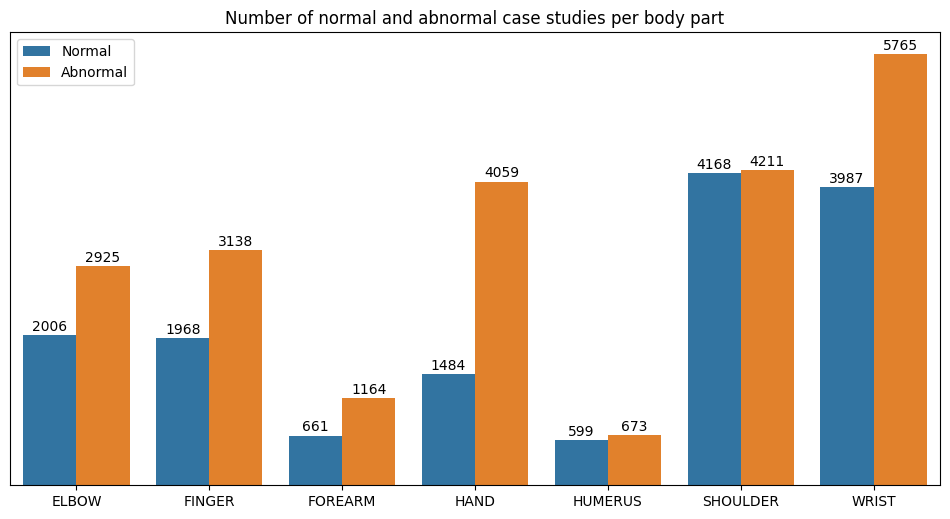

In [3]:
# Set the size and resolution of the figure
plt.figure(figsize=(12, 6), dpi=100)

# Create a count plot using Seaborn, sorting the 'type' variable
ax = sns.countplot(data=df_train, x=df_train['type'].sort_values(), hue=df_train['class'])

# Add labels to the bars with counts, using padding for better visibility
ax.bar_label(ax.containers[0], padding=1)
ax.bar_label(ax.containers[1], padding=1)

# Remove x-axis and y-axis labels and ticks for clarity
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

# Set the title of the plot
plt.title('Number of normal and abnormal case studies per body part')

# Add a legend with labels 'Normal' and 'Abnormal'
plt.legend(loc=0, labels=['Normal', 'Abnormal'])

# Display the plot
plt.show()

#### 2.2 Data Preprocessing

To improve the performance in image recognition, we will use the **image data augmentation** technique. 

`ImageDataGenerator` is a crucial component for data preprocessing. It serves a dual purpose: first, to apply real-time data augmentation during training, enhancing the model's ability to generalize by exposing it to a variety of image transformations like rotation, zooming, and flipping. Second, it normalizes pixel values of the images to a scale between 0 and 1, which aids in model convergence by ensuring consistent input data ranges. The `flow_from_dataframe` method then utilizes the configured `ImageDataGenerator` to generate a continuous flow of preprocessed image data from the training and validation dataframes. This flow of data is essential for training and evaluating deep learning models efficiently, contributing to improved model performance and generalization on unseen data.

In [3]:
# Initialize ImageDataGenerator for trainset
datagenerator_train = ImageDataGenerator(rotation_range = 30, horizontal_flip = True,
                fill_mode = "constant", cval = 0.0, rescale = 1.0 / 255, validation_split = 0.2)

# Create the train set (images 224x224)
trainset = datagenerator_train.flow_from_dataframe(directory = dir_mura,
            dataframe = df_train, x_col = "image_path", y_col = "class",target_size = (224, 224),
            batch_size = 32, shuffle = True, class_mode = "binary")

# Initialize ImageDataGenerator for validationset
datagenerator_validation = ImageDataGenerator(rescale = 1.0 / 255)

# Create the train set (images 224x224)
validationset = datagenerator_validation.flow_from_dataframe(directory = dir_mura,
              dataframe = df_valid, x_col = "image_path", y_col = "class",target_size = (224, 224),
              batch_size = 32, shuffle = True, class_mode = "binary")


Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


### 3. Define Useful Functions

#### 3.1 Plot Functions

In [18]:
def print_results(hs, evaluate_model, metric='val_loss'):
    # Find the index and value of the minimum validation loss
    min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(hs.history[metric]))
    
    # Print the best epoch and associated metrics
    print('Best Epoch: ', idx+1)
    print("---")
    
    # Print training and validation loss
    print("Train Loss         : {0:.5f}".format(hs.history['loss'][idx]))
    print("Validation Loss    : {0:.5f}".format(hs.history['val_loss'][idx]))
    print("---")
    
    # Print training and validation accuracy
    print("Train Accuracy     : {0:.5f}".format(hs.history['binary_acc'][idx]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_binary_acc'][idx]))
    print("---")
    
    # Print training and validation precision
    print("Train Precision    : {0:.5f}".format(hs.history['precision'][idx]))
    print("Validation Precision: {0:.5f}".format(hs.history['val_precision'][idx]))
    print("---")
    
    # Print training and validation recall
    print("Train Recall       : {0:.5f}".format(hs.history['recall'][idx]))
    print("Validation Recall  : {0:.5f}".format(hs.history['val_recall'][idx]))
    print("---")
    
    # Print training and validation ROC AUC
    print("Train ROC AUC      : {0:.5f}".format(hs.history['roc_auc'][idx]))
    print("Validation ROC AUC : {0:.5f}".format(hs.history['val_roc_auc'][idx]))

def plot_history(hs, epochs, metric):
    # Print a newline for better formatting
    print()
    
    # Set the style and size of the plot
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 16
    
    # Clear any existing plots
    plt.clf()
    
    # Iterate through each label in the history dictionary
    for label in hs:
        # Plot the training and validation metric for each label
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    
    # Define x-axis ticks
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    
    # Set x-axis ticks
    plt.xticks(x_ticks)
    
    # Set y-axis limits to (0, 1) for better visibility of metrics in the typical range
    plt.ylim((0, 1))
    
    # Set x-axis label
    plt.xlabel('Epochs')
    
    # Set y-axis label based on the metric type
    plt.ylabel('Loss' if metric == 'loss' else 'Accuracy')
    
    # Display the legend
    plt.legend()
    
    # Show the plot
    plt.show()

#### 3.2 Clean Function

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### 4. Model Architectures

We will use two different model architectures to perform our classification task.
* DenseNet169 model
* VGG19 model

The above two architectures are pretrained on ImageNet 

#### 4.1 DenseNet169

DenseNet169 is a deep convolutional neural network architecture that belongs to the DenseNet (Densely Connected Convolutional Networks) family. Developed by Gao Huang, Zhuang Liu, Laurens van der Maaten, and Kilian Q. Weinberger, DenseNet169 is characterized by its densely connected blocks, which facilitate feature reuse and enhance gradient flow throughout the network. Unlike traditional architectures where each layer is connected to the subsequent one, DenseNet connects each layer to every other layer in a dense manner. This dense connectivity promotes feature reuse, reduces the vanishing gradient problem, and enhances the overall efficiency of information flow. DenseNet169 specifically has 169 layers and is pre-trained on large datasets, making it suitable for various computer vision tasks, including image classification and feature extraction.

We modified the DenseNet169 model architecture by replacing the top layer with our custom layer. Initially, we froze all layers for training, except for the top layer. In the subsequent approach, we fine-tuned the model by training all layers with a low learning rate.

On top architecture

> **Maxpool layers:** One <br>
> **Activation function:** Relu and Sigmoid(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Binary Cross Entropy <br>
> **Optimizer:** Adam - 0.0001 learning rate <br>


#### 4.1.1 Creation

In [6]:
# Ensure reproducible experiments and results
np.random.seed(999) # Numpy random seed
tf.random.set_seed(99) # Tensorflow random seed

# Load the DensetNet169 model without the top layers
desnet_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add top layers for the classification task
x = desnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x)
predictions = Dense(1, activation = 'sigmoid')(x)

# Final Model
model = Model(inputs = desnet_model.input, outputs = predictions)

# Freeze the weights of the base model so they are not trained
for layer in desnet_model.layers:
    layer.trainable = False

# Optimizer
optimizer = Adam(learning_rate = 0.0001)

# Define metrics
my_metrics = [tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
                 tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall"),
                  tf.keras.metrics.AUC(name="roc_auc", curve="ROC")]

# Compile the model
model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy', 
              metrics = my_metrics)

51877672/51877672 [==============================] - 3s 0us/step


#### 4.1.2 Training / Top Layer

In [8]:
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_desnet_model.h5', 
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

# Train the model
history = model.fit(trainset,
          batch_size=64,
          epochs=20,
          validation_data=validationset,
          verbose=1,
          callbacks=callbacks)

Epoch 1/20
1151/1151 [==============================] - 870s 741ms/step - loss: 0.5935 - binary_acc: 0.6857 - precision: 0.6480 - recall: 0.4864 - roc_auc: 0.7227 - val_loss: 0.6641 - val_binary_acc: 0.6469 - val_precision: 0.8524 - val_recall: 0.3170 - val_roc_auc: 0.7674
Epoch 2/20
1151/1151 [==============================] - 626s 544ms/step - loss: 0.5543 - binary_acc: 0.7183 - precision: 0.6960 - recall: 0.5378 - roc_auc: 0.7699 - val_loss: 0.5589 - val_binary_acc: 0.7094 - val_precision: 0.7519 - val_recall: 0.5863 - val_roc_auc: 0.7836
Epoch 3/20
1151/1151 [==============================] - 612s 532ms/step - loss: 0.5419 - binary_acc: 0.7273 - precision: 0.7102 - recall: 0.5493 - roc_auc: 0.7829 - val_loss: 0.5826 - val_binary_acc: 0.6972 - val_precision: 0.8136 - val_recall: 0.4765 - val_roc_auc: 0.7870
Epoch 4/20
1151/1151 [==============================] - 618s 537ms/step - loss: 0.5330 - binary_acc: 0.7351 - precision: 0.7192 - recall: 0.5653 - roc_auc: 0.7914 - val_loss: 0.5

#### 4.1.3 Evaluation

Best Epoch:  13
---
Train Loss     : 0.49201
Validation Loss: 0.53803
---
Train Accuracy     : 0.76388
Validation Accuracy: 0.73444
---
Train Precision     : 0.75767
Validation Presicion: 0.75316
---
Train Recall     : 0.61111
Validation Recall: 0.66209
---
Train ROC AUC     : 0.82792
Validation ROC AUC: 0.80239



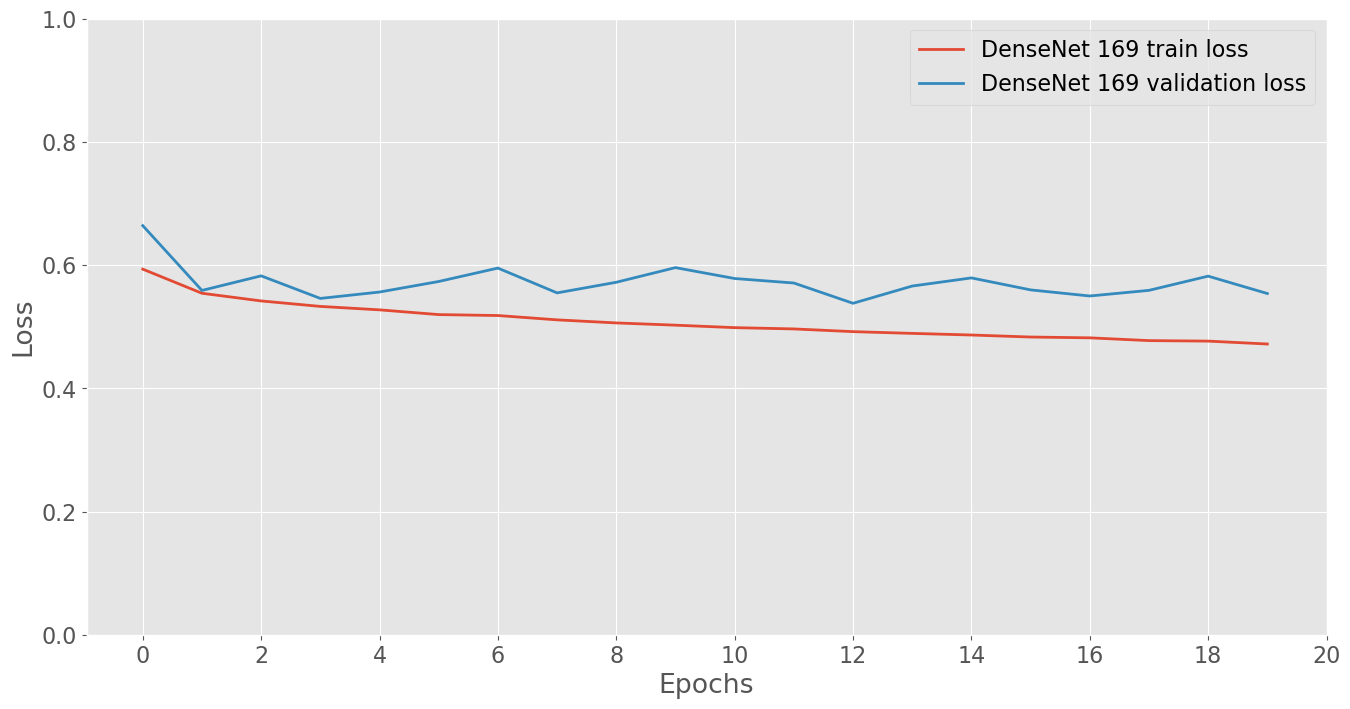

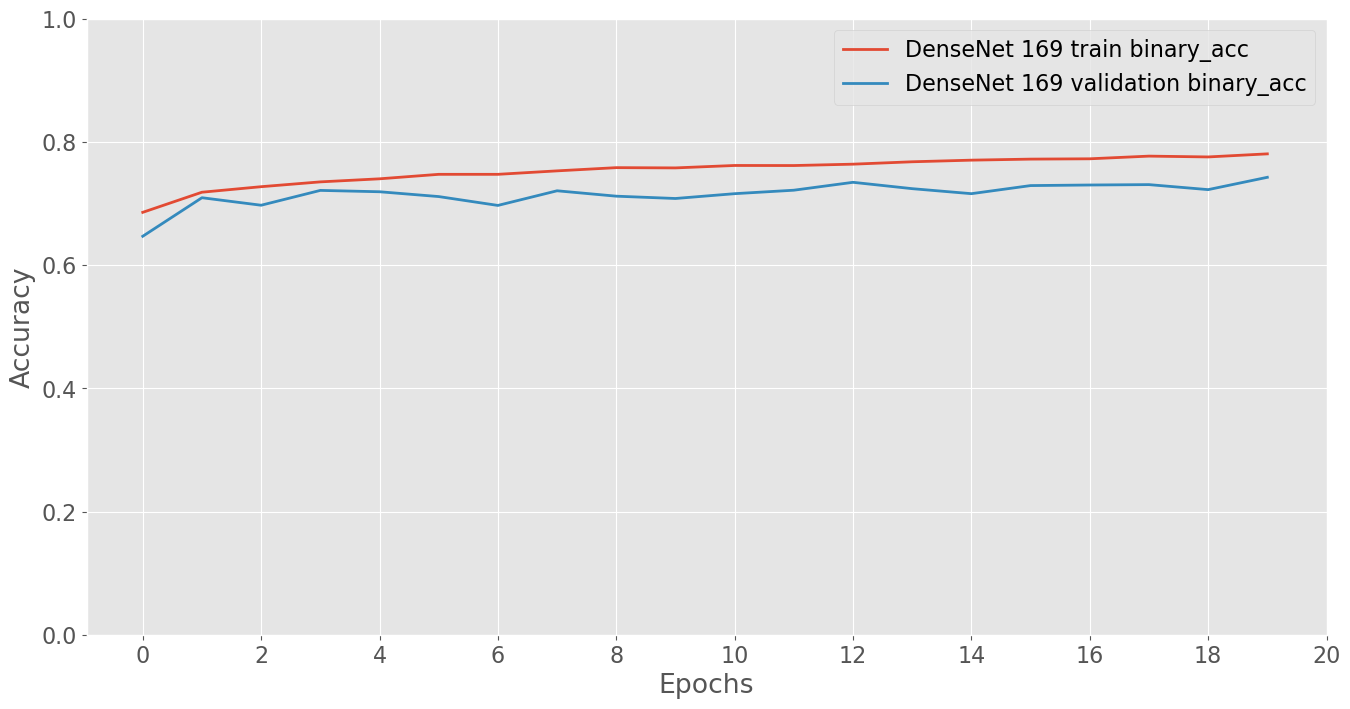

In [26]:
# Load the best weights 
model.load_weights('./Checkpoints/best_weights_desnet_model.h5')

# Evaluate model with best weights on validation data and show all the results.
score = model.evaluate(validationset, verbose=0)

# Print results
print_results(history,score)

# Plot train and validation error per epoch.
plot_history(hs={'DenseNet 169': history}, epochs=20, metric='loss')
plot_history(hs={'DenseNet 169': history}, epochs=20, metric='binary_acc')

#### 4.1.4 Fine-tuning the model

We will unfreeze all the layers and use a low learning rate (1e-5) to fine-tune the model. 

In [10]:
# Unfreeze the layers of the base model to fine-tune them
desnet_model.trainable = True

# Use a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=my_metrics)

callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_desnet_model_tune.h5', 
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

# Fine-tune the model on the training set
history = model.fit(trainset,
          batch_size=64,
          epochs=10,
          validation_data=validationset,
          verbose=1,
          callbacks=callbacks)

Epoch 1/10
1151/1151 [==============================] - 877s 745ms/step - loss: 0.5175 - binary_acc: 0.7510 - precision: 0.7407 - recall: 0.6042 - roc_auc: 0.8074 - val_loss: 0.5155 - val_binary_acc: 0.7601 - val_precision: 0.8391 - val_recall: 0.6170 - val_roc_auc: 0.8336
Epoch 2/10
1151/1151 [==============================] - 630s 548ms/step - loss: 0.4582 - binary_acc: 0.7913 - precision: 0.7976 - recall: 0.6480 - roc_auc: 0.8509 - val_loss: 0.5846 - val_binary_acc: 0.7426 - val_precision: 0.9125 - val_recall: 0.5111 - val_roc_auc: 0.8512
Epoch 3/10
1151/1151 [==============================] - 647s 562ms/step - loss: 0.4303 - binary_acc: 0.8105 - precision: 0.8192 - recall: 0.6814 - roc_auc: 0.8696 - val_loss: 0.5282 - val_binary_acc: 0.7685 - val_precision: 0.8974 - val_recall: 0.5830 - val_roc_auc: 0.8557
Epoch 4/10
1151/1151 [==============================] - 626s 544ms/step - loss: 0.4066 - binary_acc: 0.8225 - precision: 0.8342 - recall: 0.6998 - roc_auc: 0.8836 - val_loss: 0.5

#### 4.1.5 Fine-tune model evaluation

Best Epoch:  8
---
Train Loss     : 0.33602
Validation Loss: 0.48563
---
Train Accuracy     : 0.85661
Validation Accuracy: 0.80294
---
Train Precision     : 0.86816
Validation Presicion: 0.87943
---
Train Recall     : 0.76064
Validation Recall: 0.68170
---
Train ROC AUC     : 0.92112
Validation ROC AUC: 0.87198



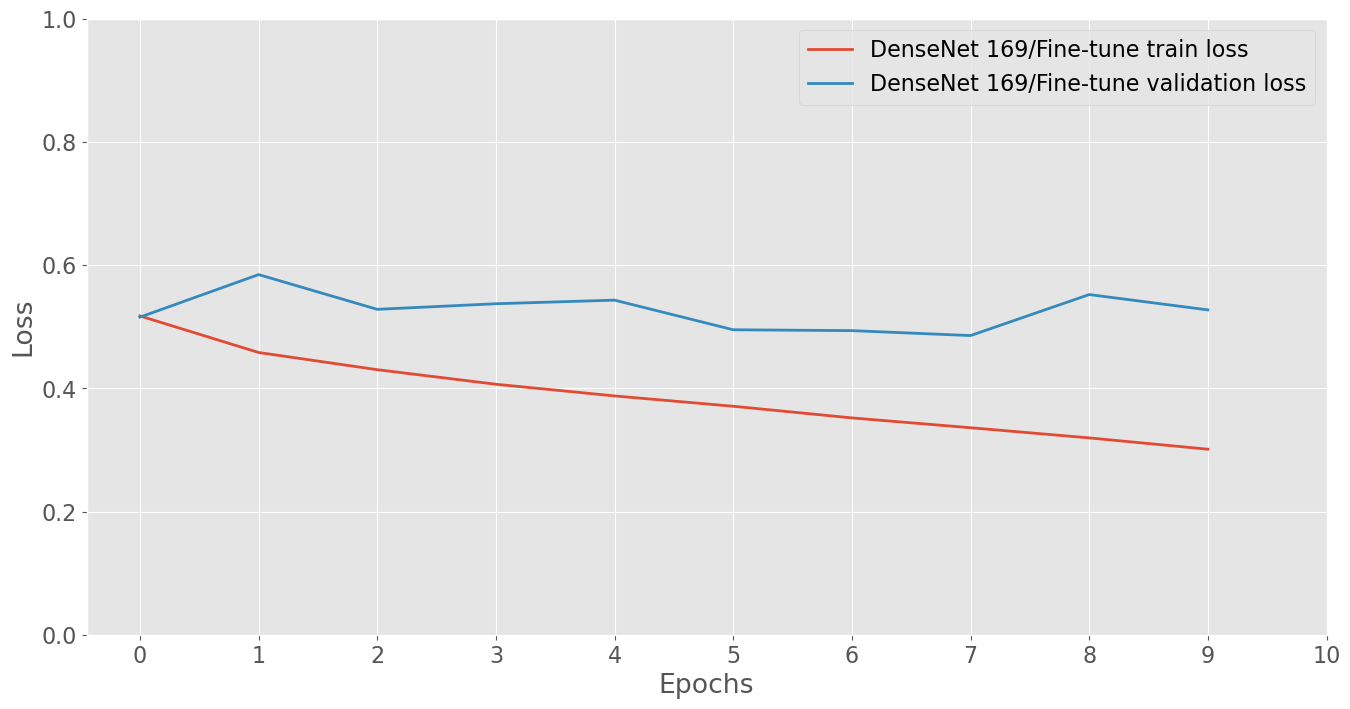

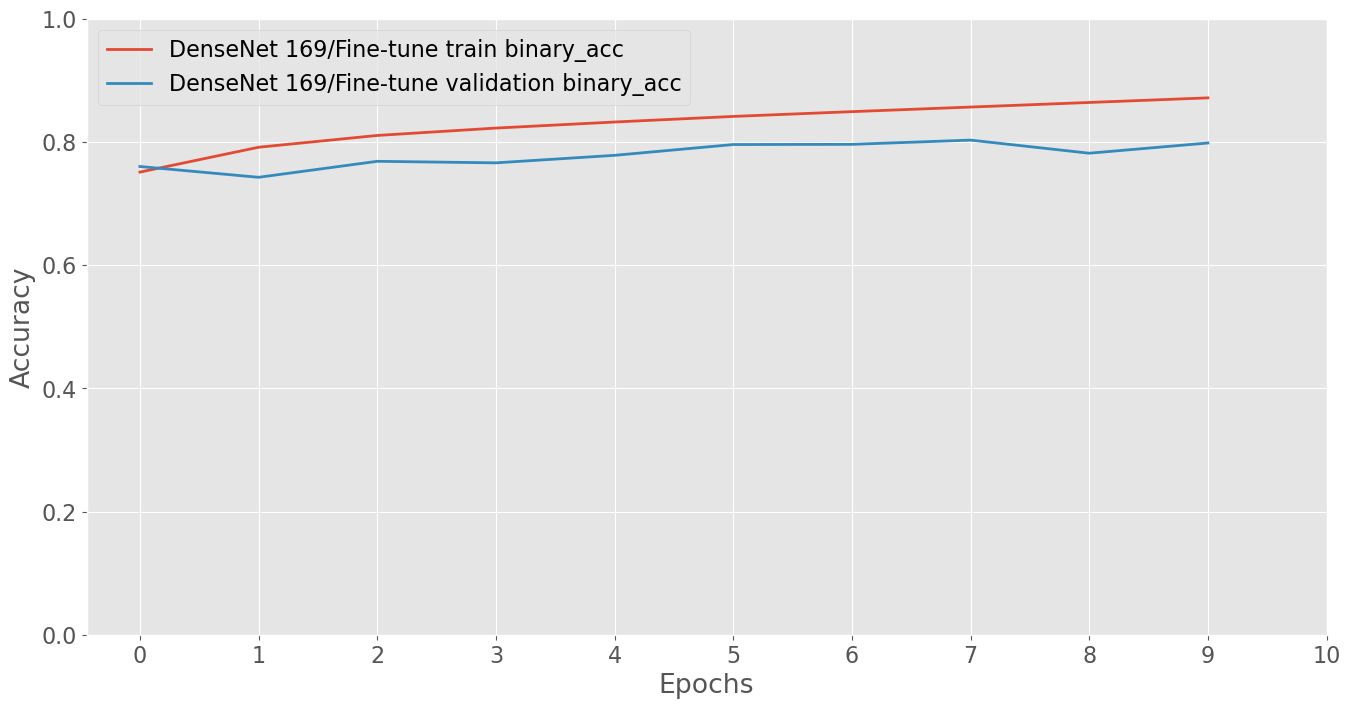

In [11]:
# Load the best weights 
model.load_weights('./Checkpoints/best_weights_desnet_model_tune.h5')

# Evaluate model with best weights on validation data and show all the results.
score = model.evaluate(validationset, verbose=0)

# Print results
print_results(history,score)

# Plot train and validation error per epoch.
plot_history(hs={'DenseNet 169/Fine-tune': history}, epochs=10, metric='loss')
plot_history(hs={'DenseNet 169/Fine-tune': history}, epochs=10, metric='binary_acc')

##### *Remarks*

- The model attains a validation accuracy of **80.3%**, which is significant imrovement compared to our own CNNs.

The superior performance of DenseNet compared to our own custom CNNs can be attributed to the following factors:

1. **Parameter Efficiency:** DenseNet utilizes a dense connectivity pattern, where each layer receives direct input from all preceding layers. This dense connectivity promotes parameter reuse and allows the network to capture more complex features with fewer parameters compared to traditional CNN architectures.

2. **Gradient Flow:** The short connections in DenseNet facilitate the flow of gradients during backpropagation. This helps in addressing the vanishing gradient problem, allowing the network to learn more effectively, especially in deep architectures.

3. **Feature Reuse:** The dense blocks in DenseNet encourage feature reuse across layers. This helps in learning hierarchical representations of features, making the network more effective in capturing both low-level and high-level features.

4. **Reduced Overfitting:** DenseNet's densely connected structure often leads to better generalization and reduced overfitting, especially when you have limited data. The dense connections act as a form of regularization, aiding the network in learning representations that generalize well to unseen examples.

5. **Architectural Design:** DenseNet's architecture is designed to encourage feature reuse and efficient parameter sharing, which can be particularly beneficial for certain types of datasets. The specific design choices in DenseNet may align well with the inherent characteristics of the dataset in question.

6. **Transfer Learning:** DenseNet models are often pretrained on large datasets (e.g., ImageNet), which enables effective transfer learning. If your dataset shares some visual patterns with the pretraining dataset, the features learned by the pretrained DenseNet can provide a strong initialization for your specific task.

In [ ]:
# Delete model
clean_up(model)

#### 4.2 VGG19

VGG19 is a convolutional neural network (CNN) architecture that belongs to the Visual Geometry Group (VGG) family. It was introduced by the Visual Graphics Group at the University of Oxford. Here are key characteristics of the VGG19 model:

1. **Depth:** VGG19 is a deep neural network with 19 weight layers, comprising 16 convolutional layers and 3 fully connected layers. The architecture is known for its simplicity and uniformity in design.

2. **Convolutional Layers:** The convolutional layers in VGG19 use small 3x3 convolutional filters with a stride of 1, and they are followed by rectified linear unit (ReLU) activation functions. The use of small filters helps to maintain a large receptive field while keeping the number of parameters manageable.

3. **Pooling Layers:** VGG19 uses max-pooling layers with a 2x2 window and a stride of 2. Pooling layers help reduce spatial dimensions and capture the most important features.

4. **Fully Connected Layers:** The convolutional layers are followed by three fully connected layers. The final layer has 1000 nodes, representing the output classes for the ImageNet dataset, for which VGG19 was originally designed.

5. **Activation Function:** ReLU activation functions are used throughout the network, introducing non-linearity and aiding in feature learning.

6. **Architecture Uniformity:** VGG19 has a consistent architecture with repeated blocks of convolutional layers followed by max-pooling layers. This uniform design simplifies the model structure and makes it easy to understand and replicate.

7. **Pretrained Models:** VGG19 models are often pretrained on large image datasets, such as ImageNet. The pretrained models can be fine-tuned for specific tasks or used as feature extractors.

8. **Applications:** VGG19 has been widely used in image classification tasks and serves as a benchmark architecture in the field of computer vision.

While VGG19 achieved success in image classification, it is worth noting that its depth and the number of parameters may make it computationally expensive compared to more modern architectures like ResNet or DenseNet. Depending on the specific requirements of a task, practitioners may choose architectures that balance performance and computational efficiency.

We modified the VGG19 model architecture by replacing its top layer with our custom layer. Initially, we chose to freeze all the layers for training, excluding the top layer. In the subsequent approach, we performed fine-tuning by training all the layers with a low learning rate.

On top architecture

> **Layers:** One <br>
> **Activation function:** Relu and Sigmoid(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Binary Cross Entropy <br>
> **Optimizer:** Adam - 0.0001 learning rate <br>

#### 4.2.1 Creation

In [11]:
# Ensure reproducible experiments and results
np.random.seed(999) # Numpy random seed
tf.random.set_seed(99) # Tensorflow random seed

# Load the DensetNet169 model without the top layers
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add top layers for the classification task
x = vgg19_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x)
predictions = Dense(1, activation = 'sigmoid')(x)

# Final Model
model = Model(inputs = vgg19_model.input, outputs = predictions)

# Freeze the weights of the base model so they are not trained
for layer in vgg19_model.layers:
    layer.trainable = False

# Optimizer
optimizer = Adam(learning_rate = 0.0001)

# Define metrics
my_metrics = [tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
                 tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall"),
                  tf.keras.metrics.AUC(name="roc_auc", curve="ROC")]

# Compile the model
model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy', 
              metrics = my_metrics)

#### 4.2.2 Training

In [12]:
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_vgg19_model.h5', 
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

# Train the model
history = model.fit(trainset,
          batch_size=64,
          epochs=20,
          validation_data=validationset,
          verbose=1,
          callbacks=callbacks)

Epoch 1/20
1151/1151 [==============================] - 721s 619ms/step - loss: 0.6372 - binary_acc: 0.6324 - precision: 0.5766 - recall: 0.3403 - roc_auc: 0.6511 - val_loss: 0.6427 - val_binary_acc: 0.6228 - val_precision: 0.7447 - val_recall: 0.3222 - val_roc_auc: 0.7024
Epoch 2/20
1151/1151 [==============================] - 573s 498ms/step - loss: 0.6128 - binary_acc: 0.6569 - precision: 0.6154 - recall: 0.4025 - roc_auc: 0.6926 - val_loss: 0.6190 - val_binary_acc: 0.6415 - val_precision: 0.7481 - val_recall: 0.3784 - val_roc_auc: 0.7250
Epoch 3/20
1151/1151 [==============================] - 570s 495ms/step - loss: 0.6025 - binary_acc: 0.6669 - precision: 0.6330 - recall: 0.4182 - roc_auc: 0.7064 - val_loss: 0.6026 - val_binary_acc: 0.6631 - val_precision: 0.7010 - val_recall: 0.5163 - val_roc_auc: 0.7325
Epoch 4/20
1151/1151 [==============================] - 566s 492ms/step - loss: 0.5962 - binary_acc: 0.6740 - precision: 0.6450 - recall: 0.4297 - roc_auc: 0.7155 - val_loss: 0.6

#### 4.2.3 Evaluation

Best Epoch:  17
---
Train Loss     : 0.55907
Validation Loss: 0.57621
---
Train Accuracy     : 0.70683
Validation Accuracy: 0.68439
---
Train Precision     : 0.70089
Validation Presicion: 0.75169
---
Train Recall     : 0.47879
Validation Recall: 0.50850
---
Train ROC AUC     : 0.75943
Validation ROC AUC: 0.76130



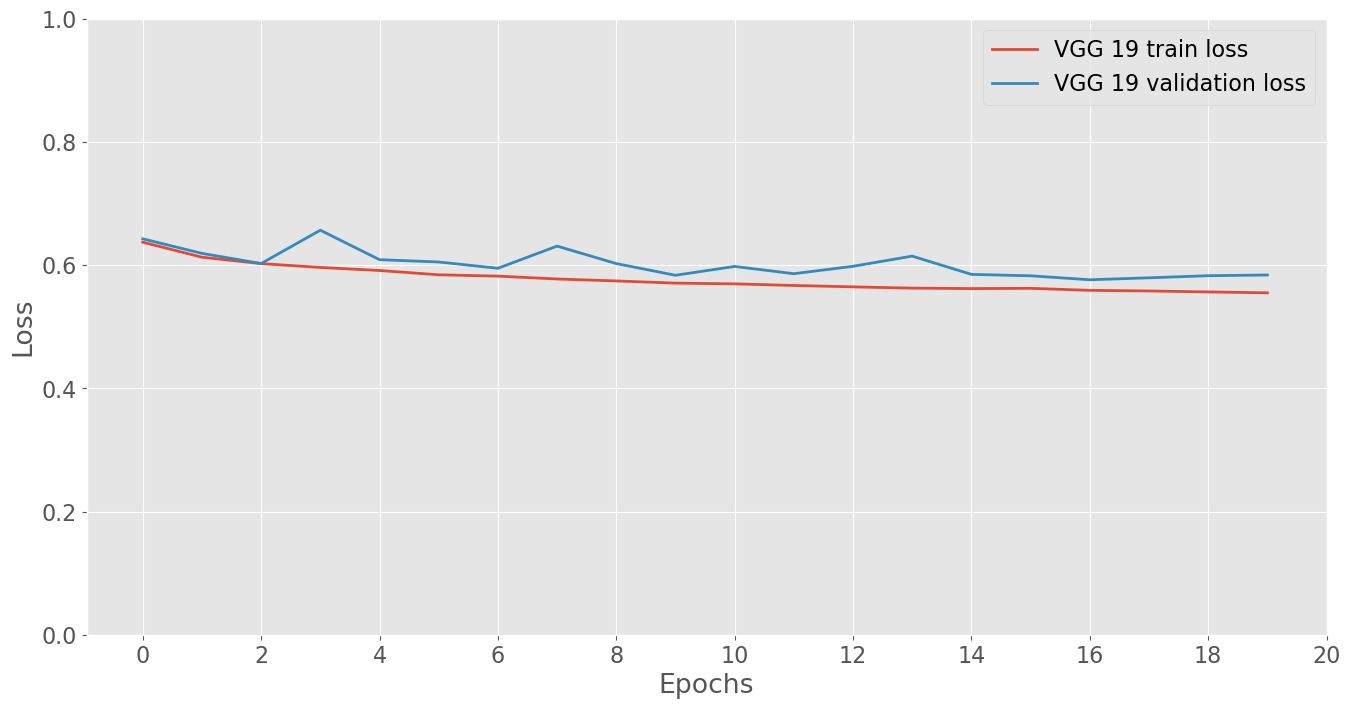

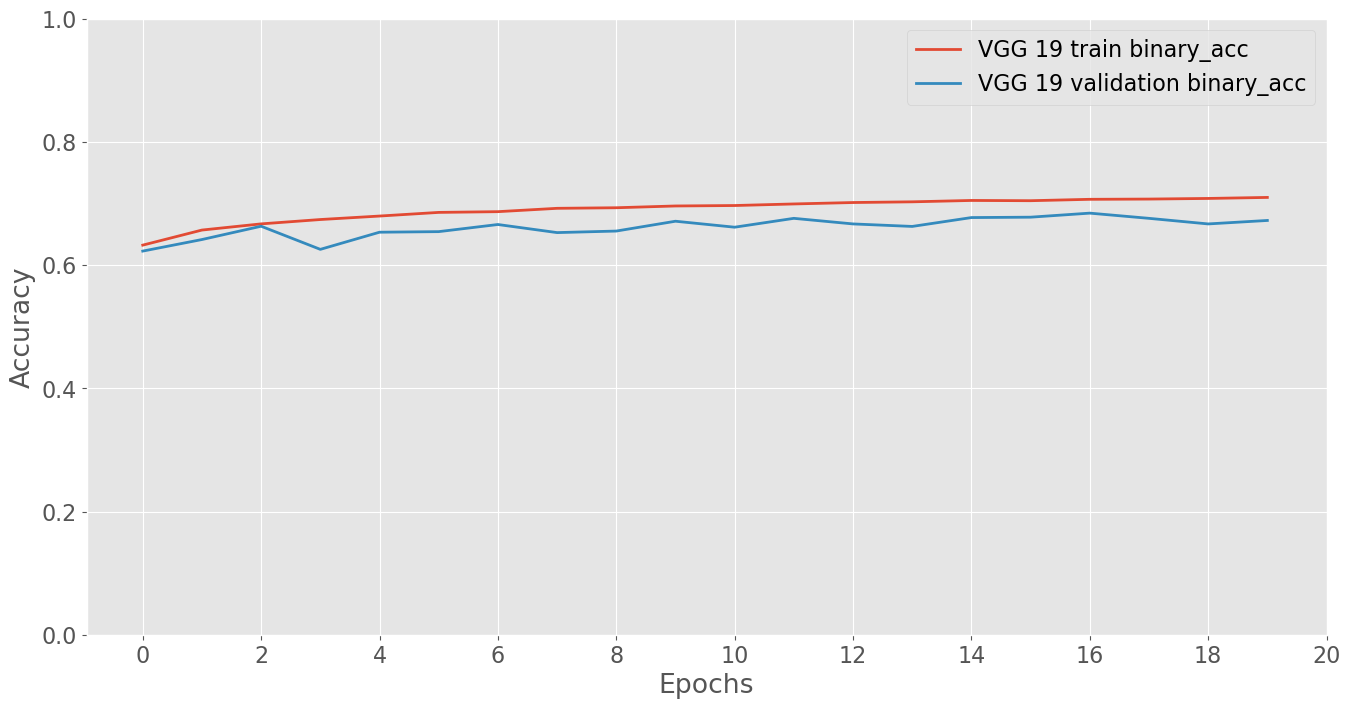

In [19]:
# Load the best weights 
model.load_weights('./Checkpoints/best_weights_vgg19_model.h5')

# Evaluate model with best weights on validation data and show all the results.
score = model.evaluate(validationset, verbose=0)

# Print results
print_results(history,score)

# Plot train and validation error per epoch.
plot_history(hs={'VGG 19': history}, epochs=20, metric='loss')
plot_history(hs={'VGG 19': history}, epochs=20, metric='binary_acc')

#### 4.2.4 Fine-tuning the model

We will unfreeze all the layers and use a low learning rate (1e-5) to fine-tune the model. 

In [20]:
# Unfreeze the layers of the base model to fine-tune them
vgg19_model.trainable = True

# Use a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=my_metrics)

callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_vgg19_model_tune.h5', 
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

# Fine-tune the model on the training set
history = model.fit(trainset,
          batch_size=64,
          epochs=10,
          validation_data=validationset,
          verbose=1,
          callbacks=callbacks)

Epoch 1/10
1151/1151 [==============================] - 635s 548ms/step - loss: 0.5523 - binary_acc: 0.7163 - precision: 0.7486 - recall: 0.4637 - roc_auc: 0.7658 - val_loss: 0.5337 - val_binary_acc: 0.7301 - val_precision: 0.7908 - val_recall: 0.5928 - val_roc_auc: 0.8000
Epoch 2/10
1151/1151 [==============================] - 623s 541ms/step - loss: 0.5128 - binary_acc: 0.7532 - precision: 0.7941 - recall: 0.5255 - roc_auc: 0.8041 - val_loss: 0.5305 - val_binary_acc: 0.7338 - val_precision: 0.7218 - val_recall: 0.7222 - val_roc_auc: 0.8153
Epoch 3/10
1151/1151 [==============================] - 634s 551ms/step - loss: 0.4861 - binary_acc: 0.7730 - precision: 0.8038 - recall: 0.5798 - roc_auc: 0.8264 - val_loss: 0.5769 - val_binary_acc: 0.7238 - val_precision: 0.9029 - val_recall: 0.4739 - val_roc_auc: 0.8146
Epoch 4/10
1151/1151 [==============================] - 650s 565ms/step - loss: 0.4667 - binary_acc: 0.7843 - precision: 0.8092 - recall: 0.6098 - roc_auc: 0.8421 - val_loss: 0.4

#### 4.2.5 Fine-tune model evaluation

Best Epoch:  7
---
Train Loss     : 0.42026
Validation Loss: 0.49108
---
Train Accuracy     : 0.81488
Validation Accuracy: 0.78793
---
Train Precision     : 0.83129
Validation Presicion: 0.82921
---
Train Recall     : 0.67982
Validation Recall: 0.70131
---
Train ROC AUC     : 0.87346
Validation ROC AUC: 0.85201



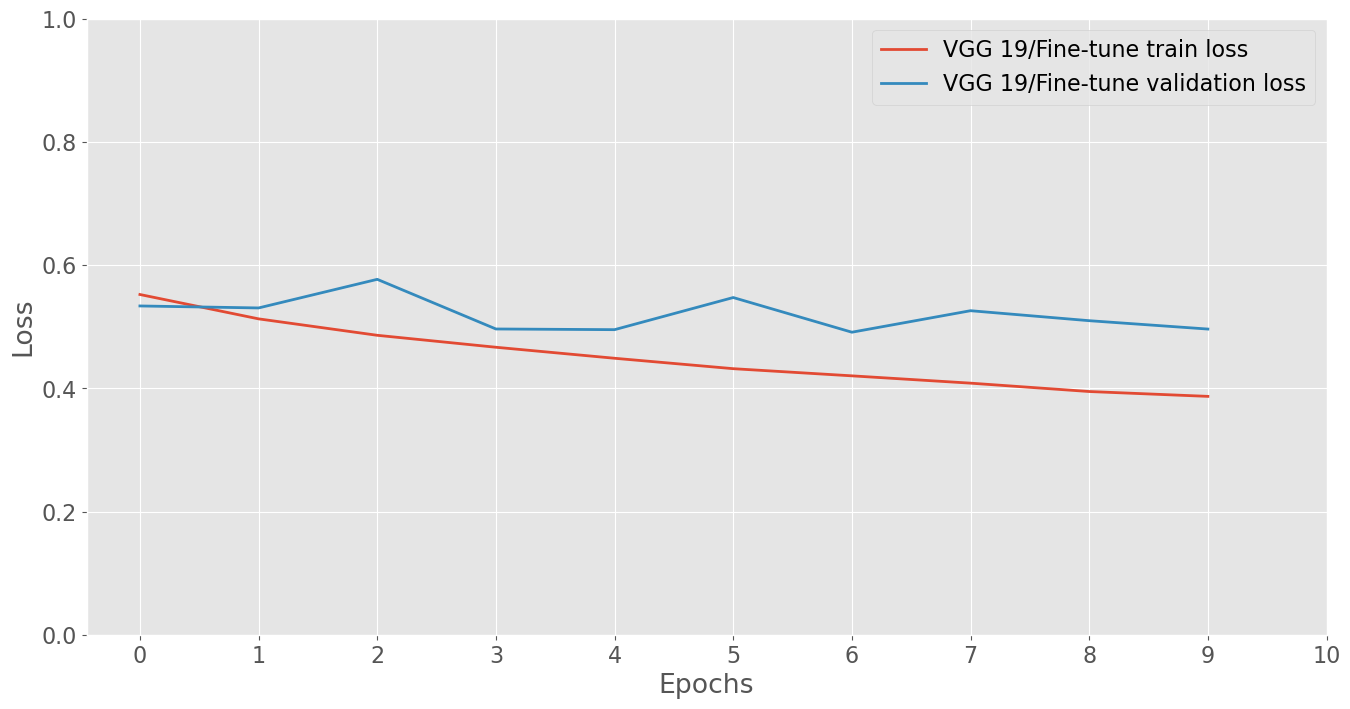

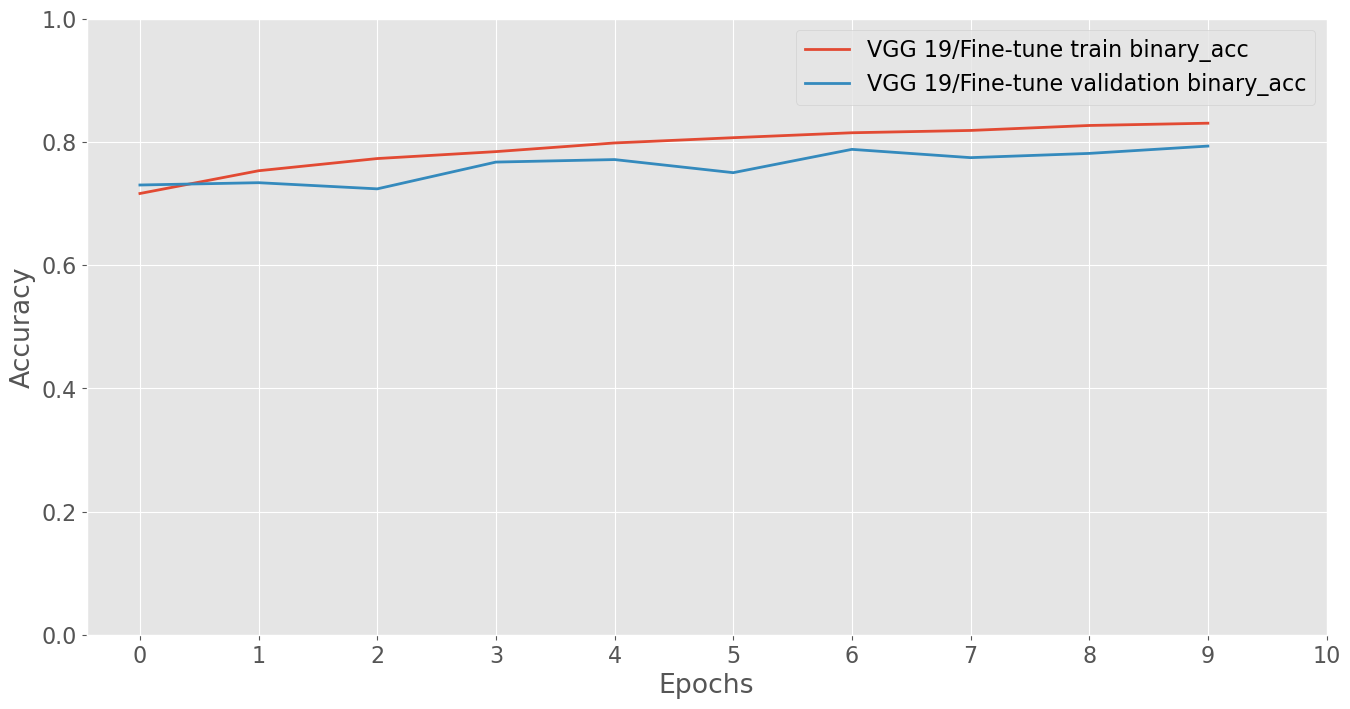

In [21]:
# Load the best weights 
model.load_weights('./Checkpoints/best_weights_vgg19_model_tune.h5')

# Evaluate model with best weights on validation data and show all the results.
score = model.evaluate(validationset, verbose=0)

# Print results
print_results(history,score)

# Plot train and validation error per epoch.
plot_history(hs={'VGG 19/Fine-tune': history}, epochs=10, metric='loss')
plot_history(hs={'VGG 19/Fine-tune': history}, epochs=10, metric='binary_acc')

##### *Remarks*

- The model attains a validation accuracy of **78.8%**, which is slighly lower than the one we acheived with DenseNet169.

Several factors could contribute to VGG19 performing slightly worse than DenseNet169:

1. **Parameter Efficiency of DenseNet**: DenseNet has a more parameter-efficient architecture compared to VGG19. DenseNet's dense connectivity pattern allows for better feature reuse across layers, leading to a more compact model with fewer parameters, which can be beneficial, especially when dealing with limited data.

2. **Dense Connectivity**: DenseNet's densely connected blocks facilitate the flow of gradients through the network during training, enabling better optimization. In contrast, VGG19 relies on a more sequential architecture, which may lead to challenges in gradient flow, particularly in deeper networks.

3. **Vanishing Gradient**: VGG19, with its deeper architecture, might suffer from vanishing gradient problems during backpropagation, especially in the early layers. DenseNet's dense connections can help mitigate this issue by providing shorter paths for gradient flow.

4. **Feature Reuse in DenseNet**: The dense connections in DenseNet allow each layer to access the features from all preceding layers. This enhances feature reuse, enabling the network to capture more intricate patterns and dependencies in the data, which might be crucial for the given dataset.

5. **Dataset Characteristics**: DenseNet's performance advantage may be more pronounced on certain types of datasets. If the dataset exhibits hierarchical and densely connected features, DenseNet could excel in capturing these relationships.

6. **Transfer Learning Effectiveness**: The effectiveness of transfer learning depends on the pre-trained model's architecture and the similarity of the source and target domains. DenseNet's pre-trained weights might be more suitable for the target dataset than those of VGG19.